In [1]:
import file_locations
import innvestigate
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import os
from keras.applications import vgg16
from keras.models import load_model
from keras.preprocessing import image as image_utils
from keras import Model
import keras

Using TensorFlow backend.


In [2]:
#load our 3 models to analyze, remove softmax from each
id_model = load_model(file_locations.PATH_TO_CHECKPOINTS+'2020.02.24-0018-vpnlidentity-noage/2020.02.24-0018-vpnlidentity-noage0.weights.hdf5')
id_model.layers[-1].activation = keras.activations.relu












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [3]:
#id_model_2 = load_model(file_locations.PATH_TO_CHECKPOINTS+'weights.2020.02.17-2359-vpnlidentity.hdf5')
#out = id_model_2.layers[-2].output
#id_model_2 = Model(id_model_2.inputs, out)

gender_model = load_model(file_locations.PATH_TO_CHECKPOINTS+'2020.02.23-2108-vpnlgender-noage/2020.02.23-2108-vpnlgender-noage1.weights.hdf5')
gender_model.layers[-1].activation = keras.activations.relu


## Relevance Analysis

In [4]:
# define model analyser
analyzers = [];
analyzers.append(innvestigate.create_analyzer("lrp.sequential_preset_b_flat", id_model));
#analyzers.append(innvestigate.create_analyzer("lrp.sequential_preset_b_flat", id_model_2));
analyzers.append(innvestigate.create_analyzer("lrp.sequential_preset_b_flat", gender_model));

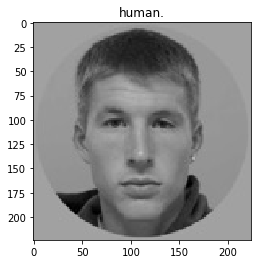

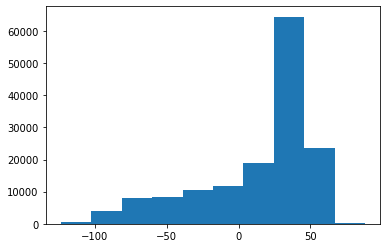

In [5]:
# grab image from database
image = image_utils.load_img(file_locations.PATH_TO_VPNL_ID+'/088/88_m_0.resample.jpg', target_size=(224,224))
plt.imshow(image)
plt.title("human.")
x = image_utils.img_to_array(image)
x = np.expand_dims(x,0)
x = vgg16.preprocess_input(x)
plt.figure()
plt.hist(x.flatten());

In [6]:
id_map = analyzers[0].analyze(x)
gender_map = analyzers[1].analyze(x)

In [7]:
from matplotlib.colors import LinearSegmentedColormap
blueblackred_colors = np.array(
  [
      [0.8, 1, 1],  # cyan-white
      [0, 1, 1],  # cyan
      [0, 0, 1],  # blue
      [0, 0, 0],  # black
      [1, 0, 0],  # red
      [1, 1, 0],  # yellow
      [1, 1, 0.8],  # yellow-white
  ]
)
blueblackred = LinearSegmentedColormap.from_list("blueblackred", blueblackred_colors)

/share/kalanit/users/jnani/strelka_tf1_venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


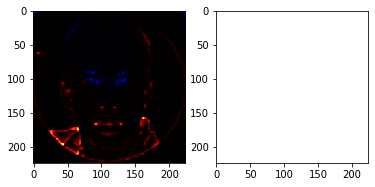

In [8]:
a = id_map

r = a[0].sum(axis=2)
r /= np.max(np.abs(r))
plt.subplot(1,2,1)
plt.imshow(r, cmap=blueblackred, clim=[-1,1]);

a = gender_map

r = a[0].sum(axis=2)
r /= np.max(np.abs(r))
plt.subplot(1,2,2)
plt.imshow(r, cmap=blueblackred, clim=[-1,1]);

## Batch Processing

In [9]:
front_view_filenames = []
front_view_classes = []
for base, dirs, files in os.walk(file_locations.PATH_TO_VPNL_ID): 
    for filename in files:
        if "000." in filename or "_0." in filename:
            front_view_filenames.append(base+"/"+filename)

In [10]:
len(front_view_filenames)
front_view_filenames[68]

'/biac2/kgs/projects/deepRFs/FaceDataCp/088/88_m_0.resample.jpg'

In [11]:
def relevanceMap(f,analyzer,hush=False,mask=np.ones((224,224,3)),BS=-1):
    BS = len(f) if (BS < 0) else BS;
    pics = []
    batch = np.ones((len(f),224,224,3))
    i = 0;
    e = 0;
    r = [];
    while (i < len(f)):
        for offset in range(BS):
            if(offset+i >= len(f)): break;
            image = image_utils.load_img(f[i+offset], target_size=(224,224))
            x = image_utils.img_to_array(image)*mask
            batch[i+offset,:,:,:] = x
            pics.append(image)
            e = offset+i;

        batch[i:e+1,:,:,:] = vgg16.preprocess_input(batch[i:e+1,:,:,:])
        a = analyzer.analyze(batch[i:e+1,:,:,:])
        r.extend(a)
        i+=BS;
   
    r = np.array(r).sum(axis=3)
    m = np.max(np.abs(r), axis=(1,2))
    r /= np.expand_dims(np.expand_dims(m,axis=-1),axis=-1)
    r[np.isnan(r)] = 0;
    return (r, pics)

In [13]:
(rs_kgs_g,ps_kgs_g) = relevanceMap(front_view_filenames, analyzers[1], BS = 10)
for i in range(len(rs_kgs_g)):
    np.savez(file_locations.PATH_TO_CHECKPOINTS+"../relevances_gender/rmap"+str(i)+".npz", rs_kgs_g[i])

(rs_kgs,ps_kgs) = relevanceMap(front_view_filenames, analyzers[0], BS = 10)
for i in range(len(rs_kgs)):
    np.savez(file_locations.PATH_TO_CHECKPOINTS+"../relevances_id/rmap"+str(i)+".npz", rs_kgs[i])

/share/kalanit/users/jnani/strelka_tf1_venv/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


/share/kalanit/users/jnani/strelka_tf1_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


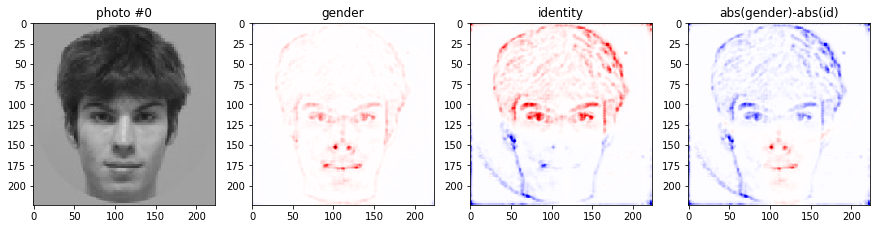

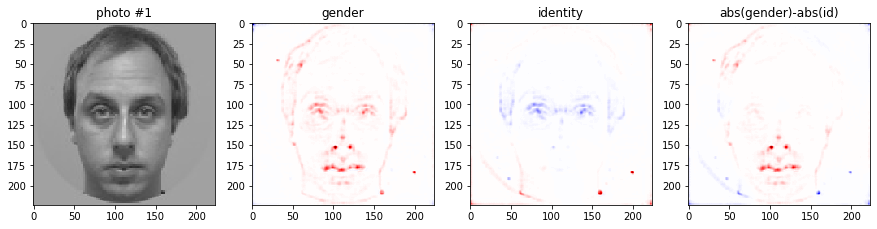

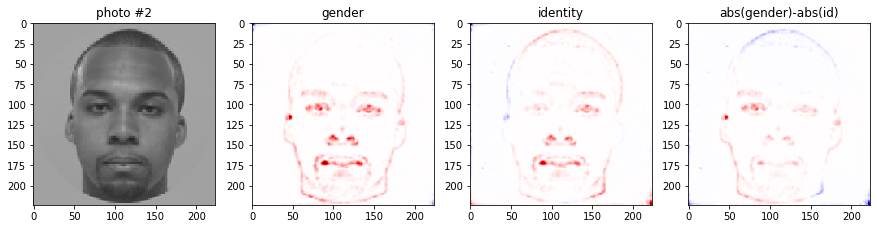

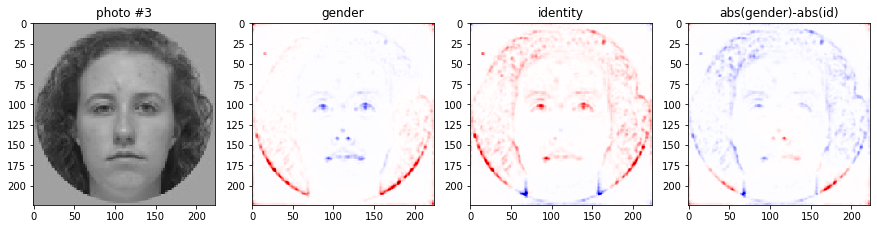

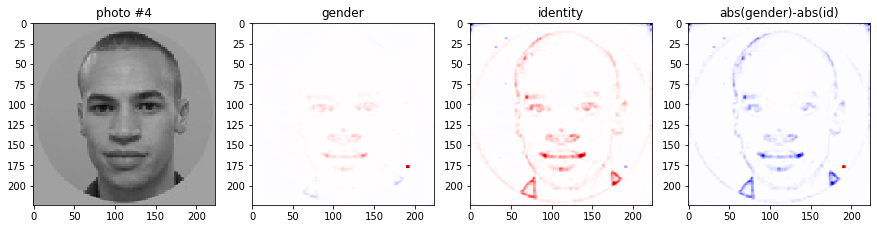

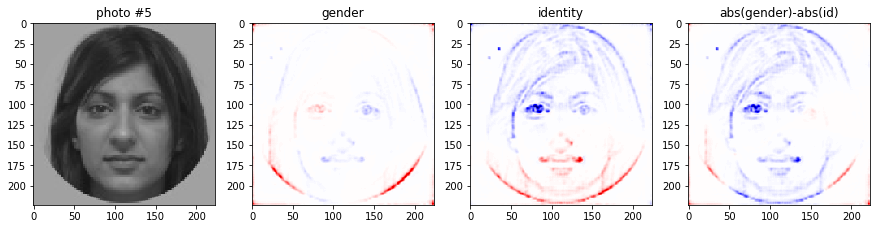

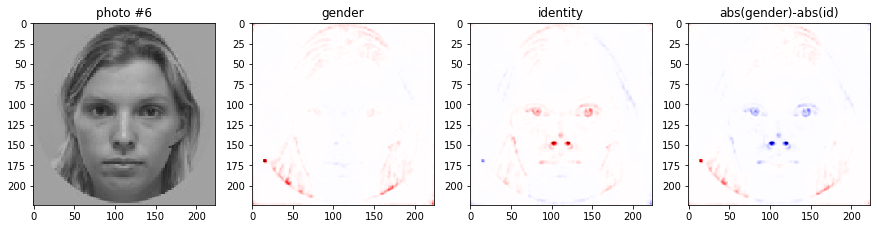

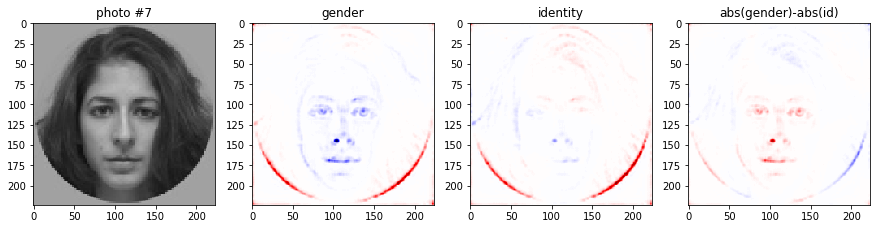

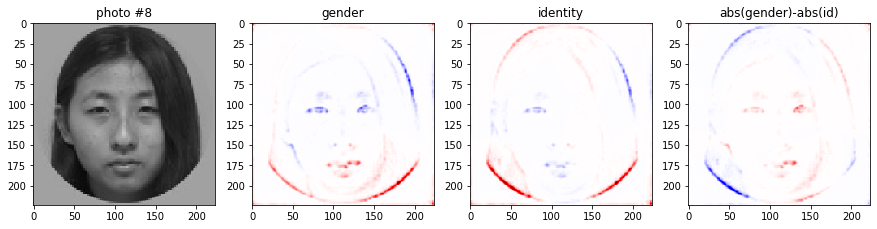

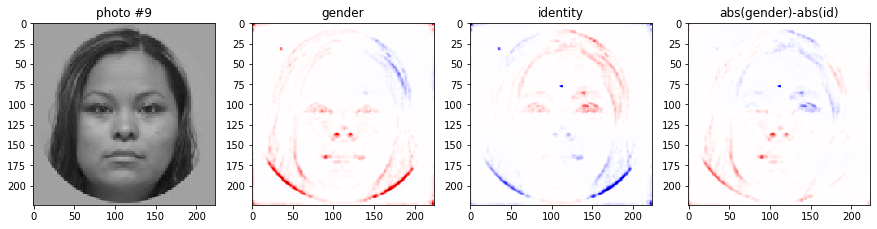

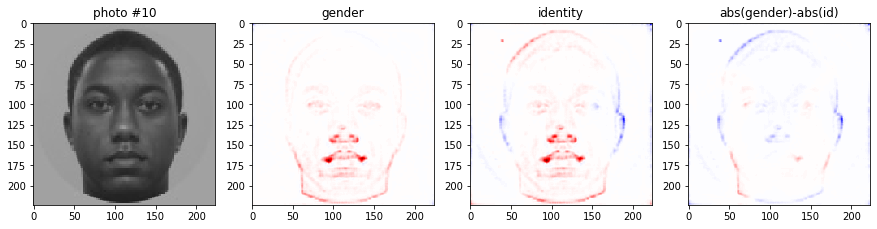

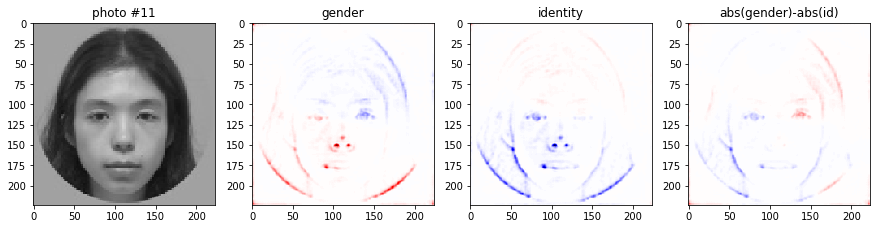

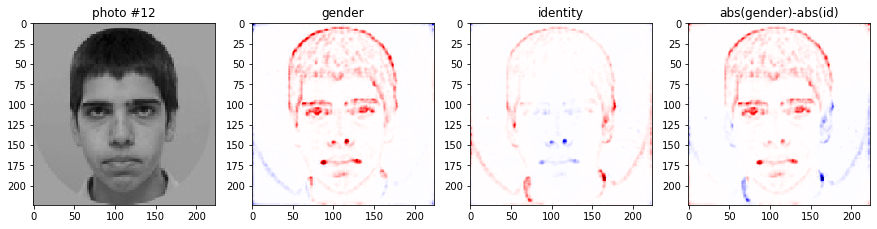

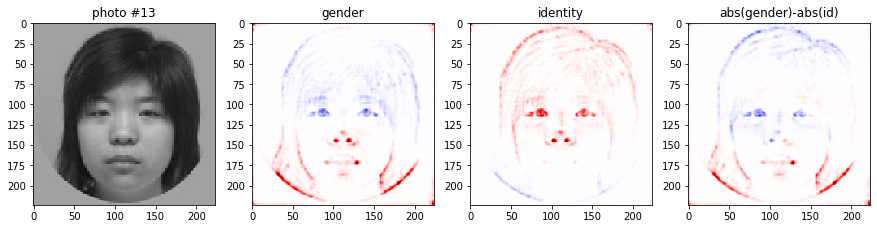

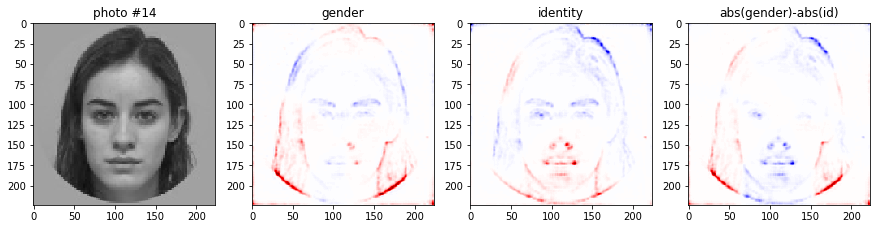

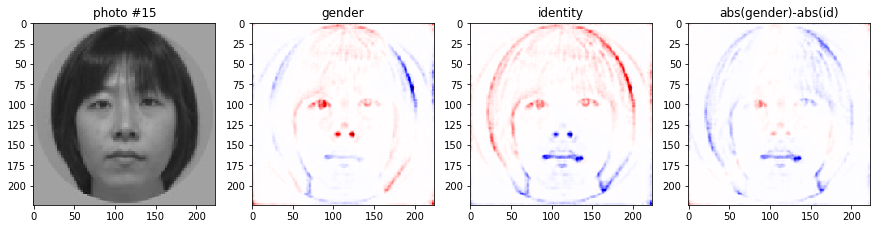

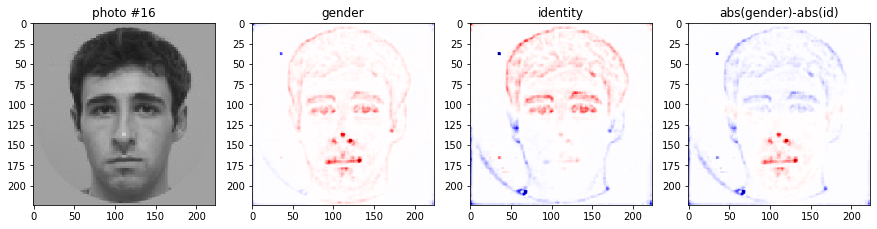

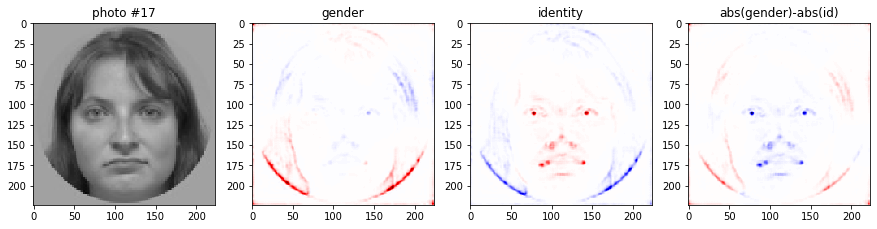

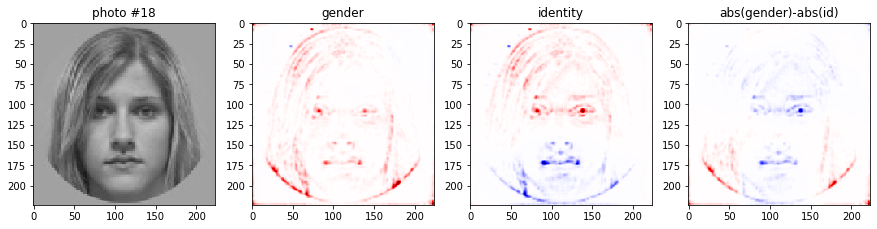

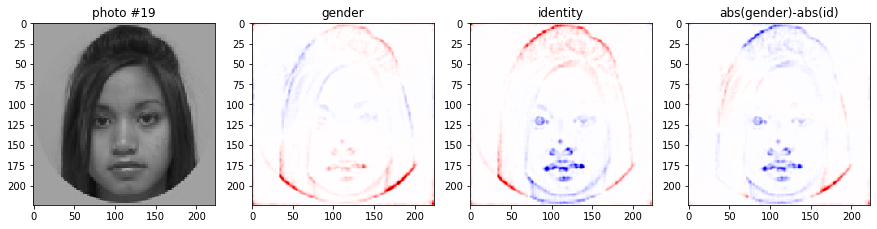

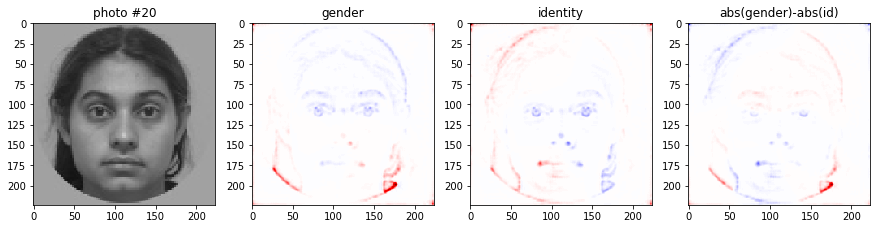

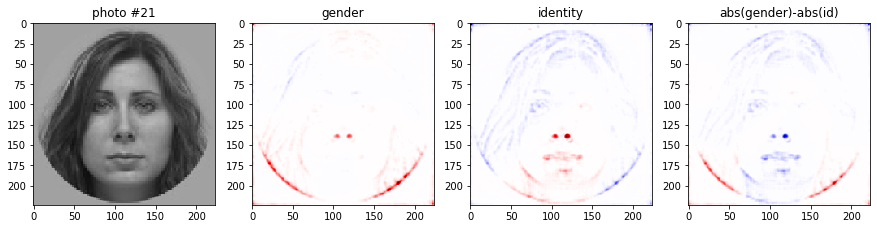

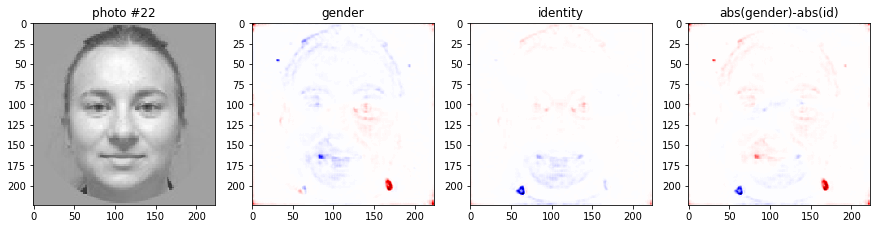

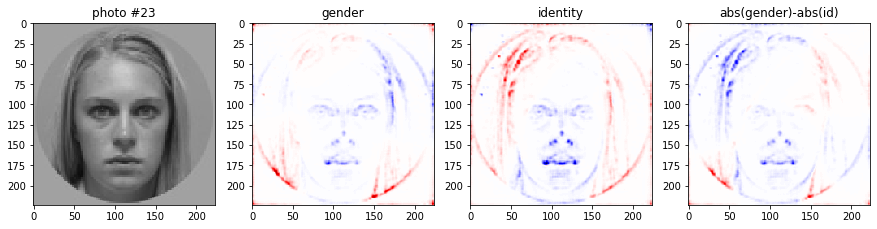

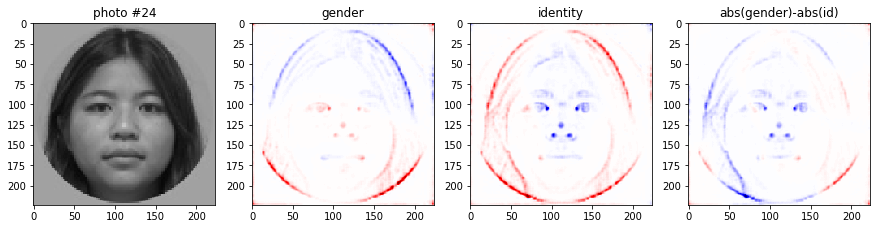

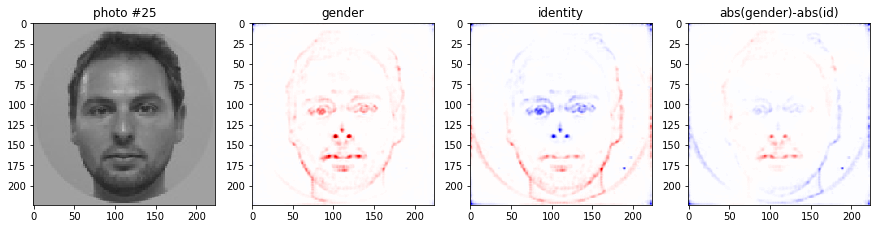

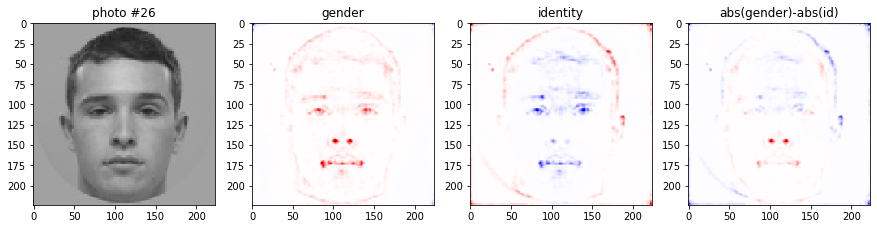

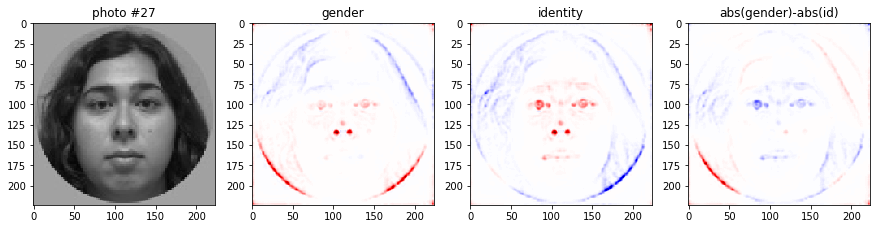

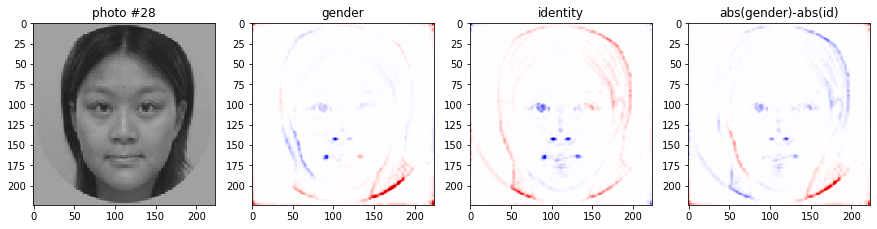

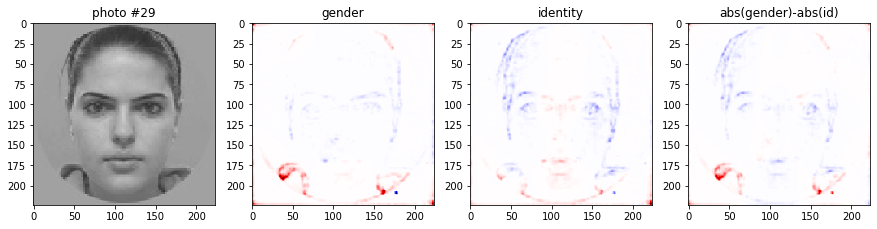

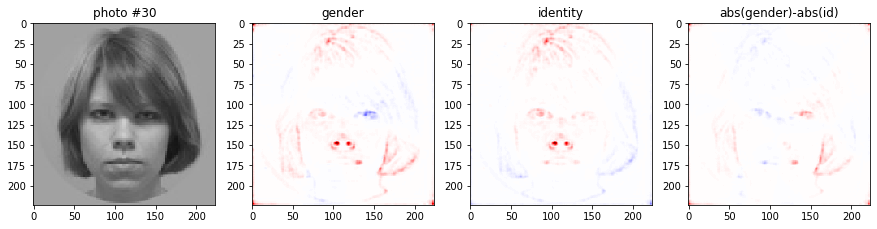

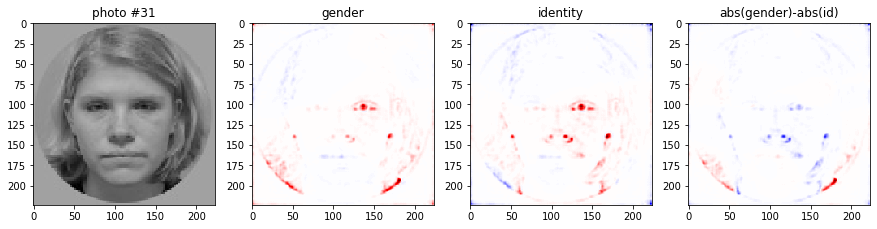

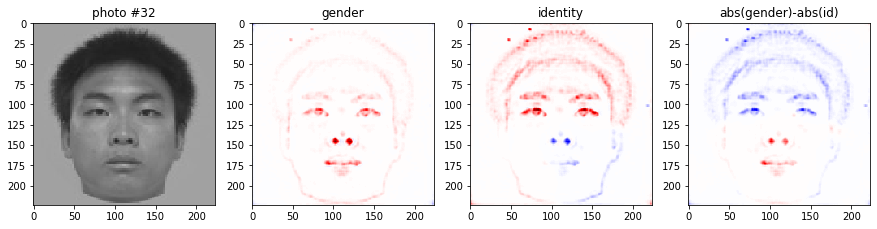

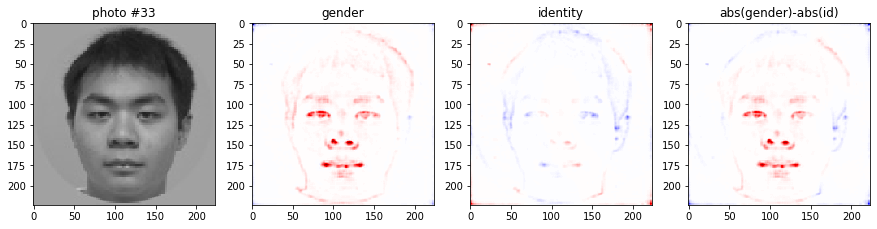

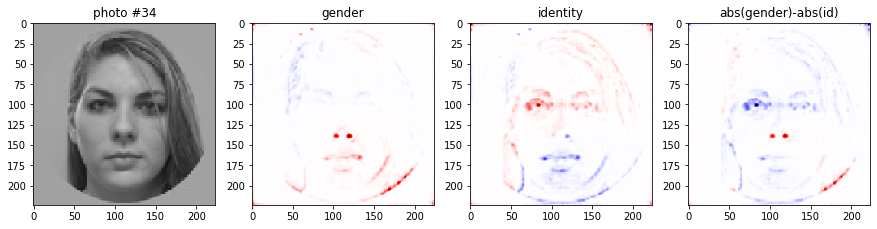

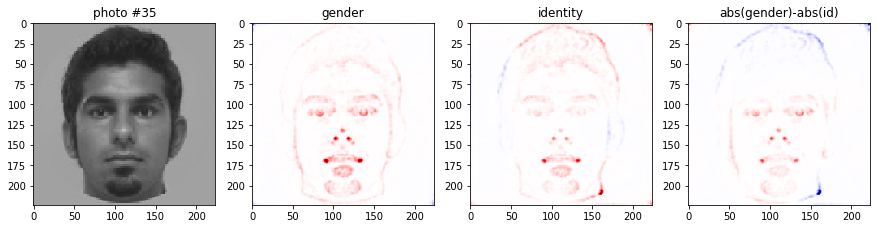

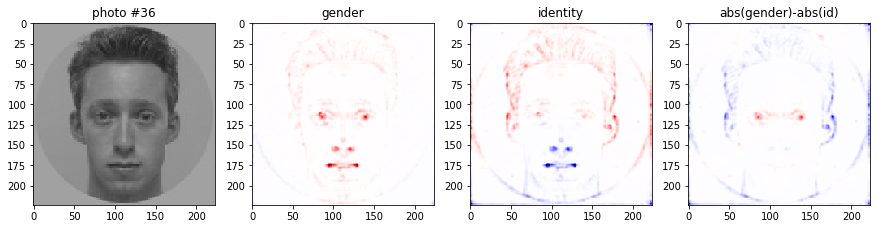

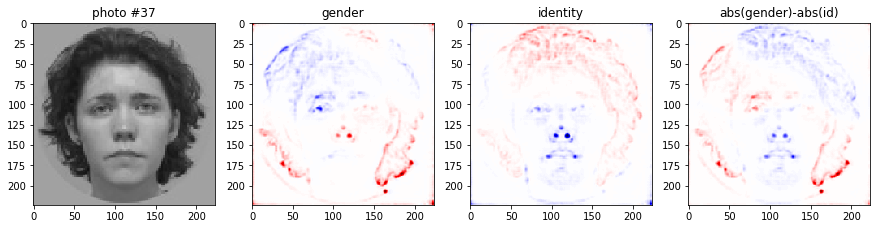

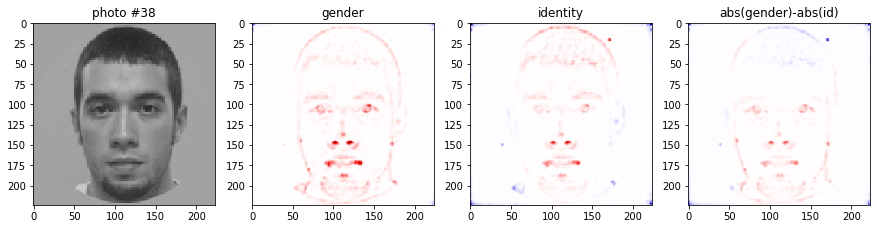

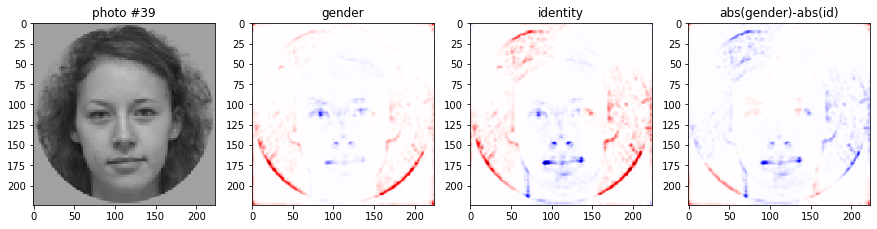

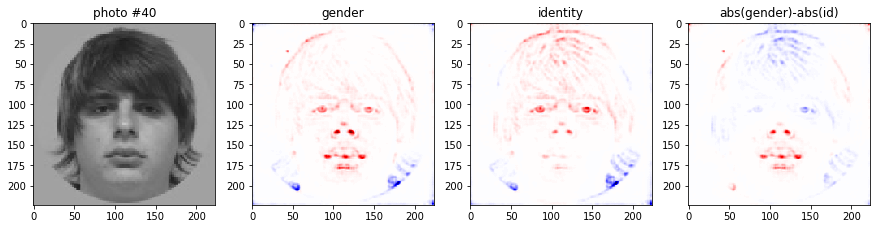

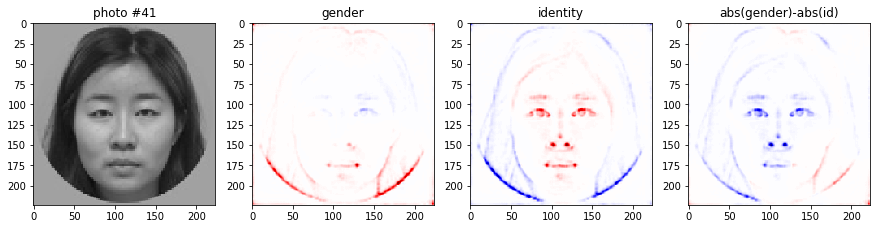

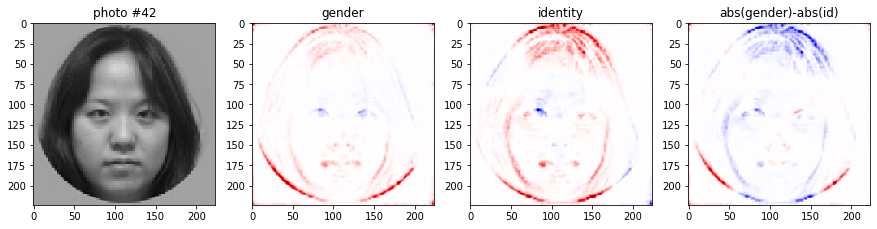

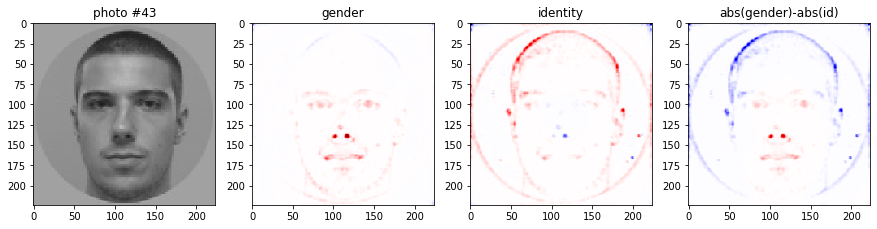

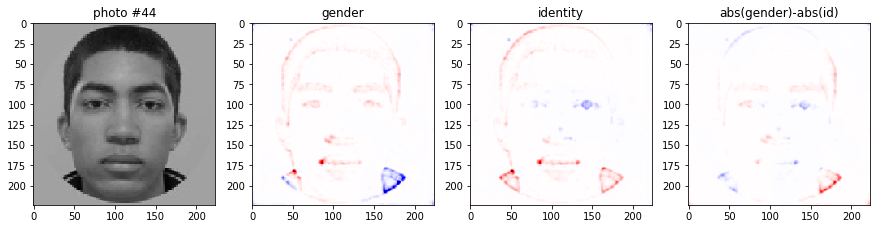

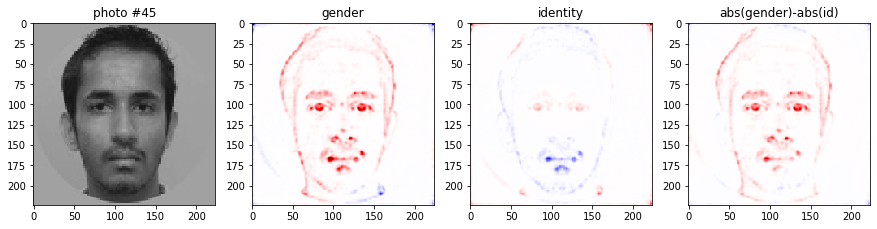

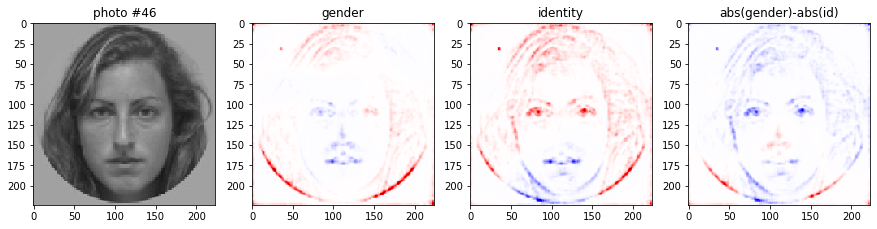

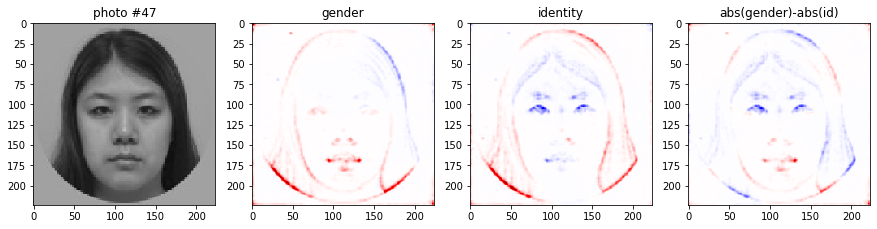

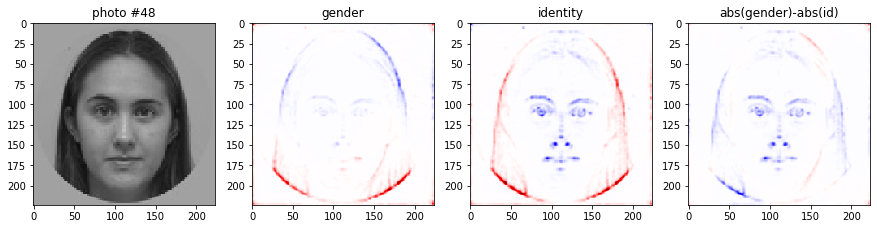

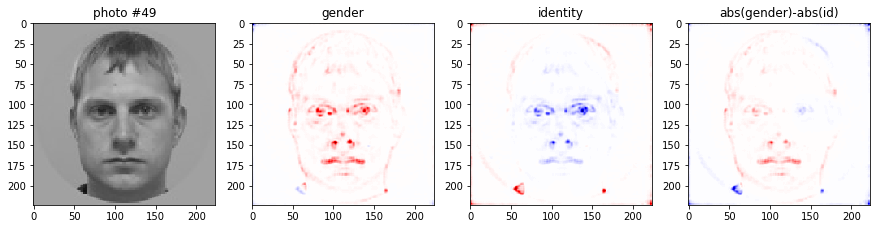

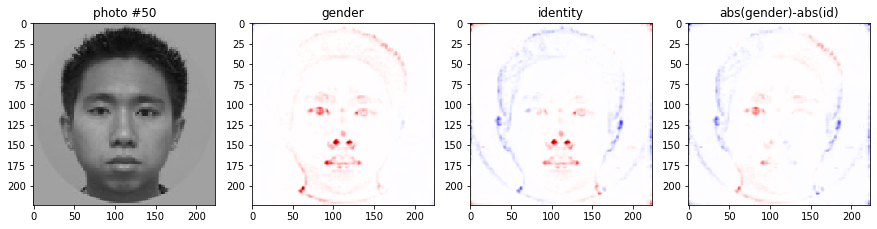

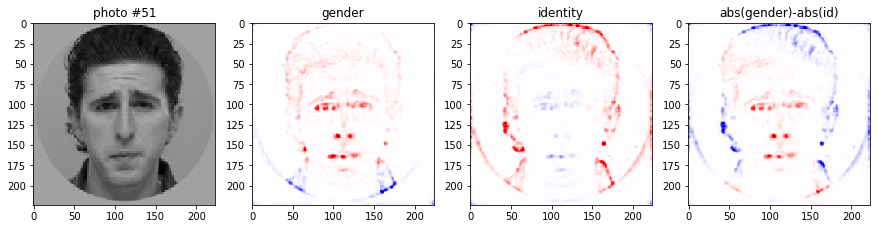

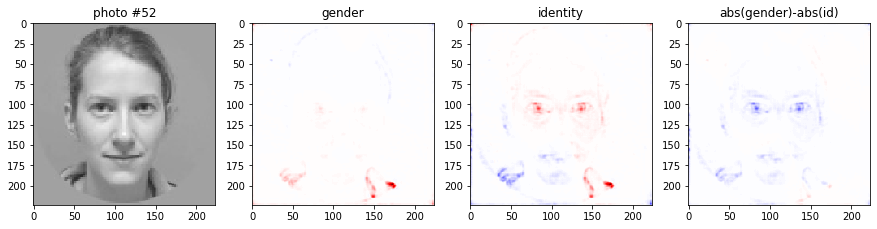

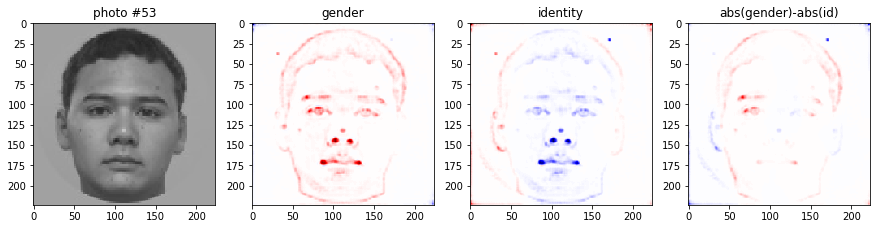

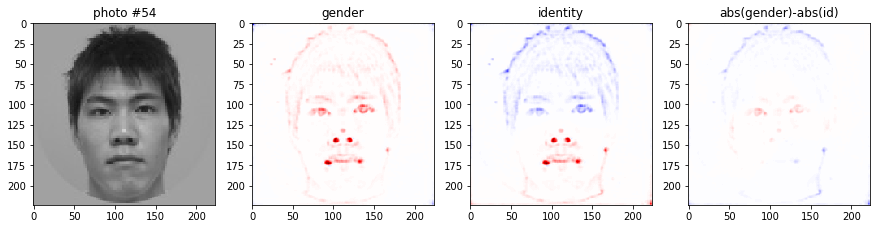

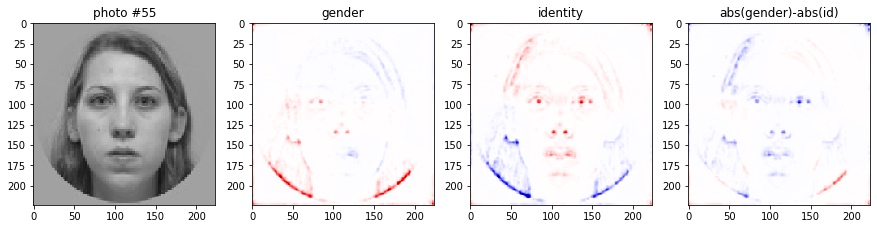

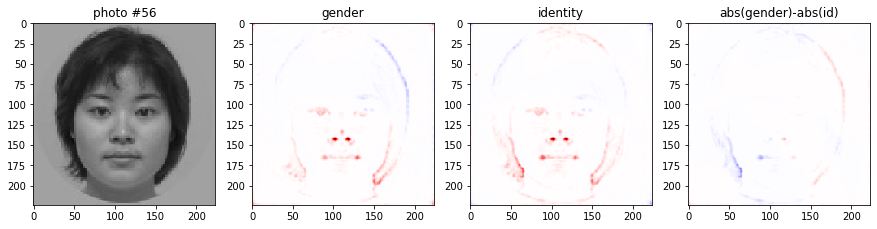

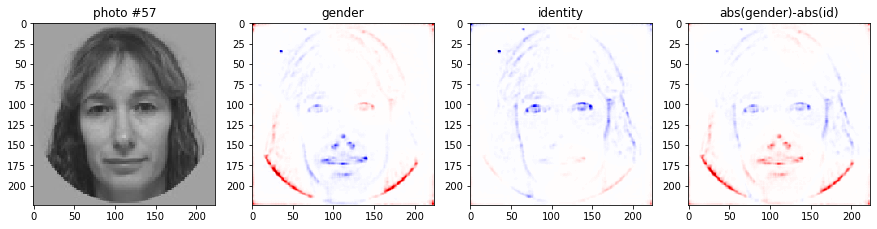

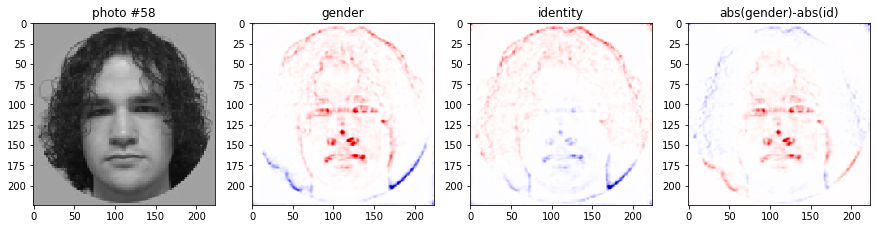

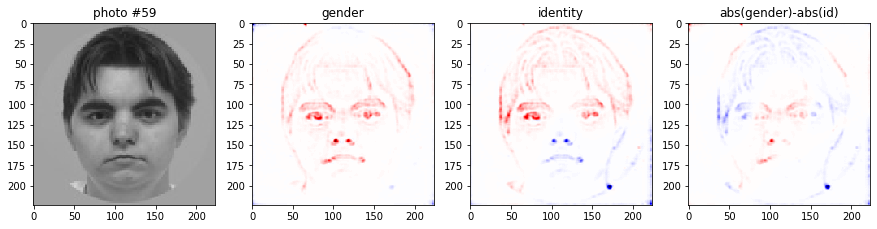

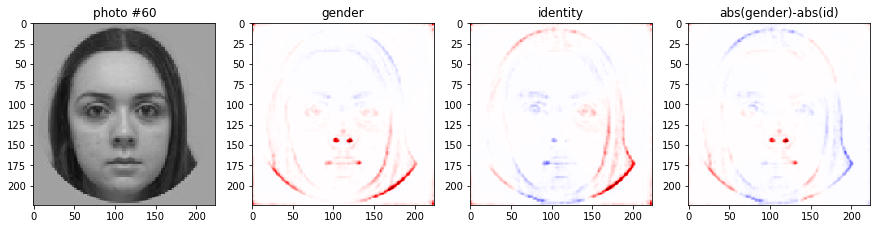

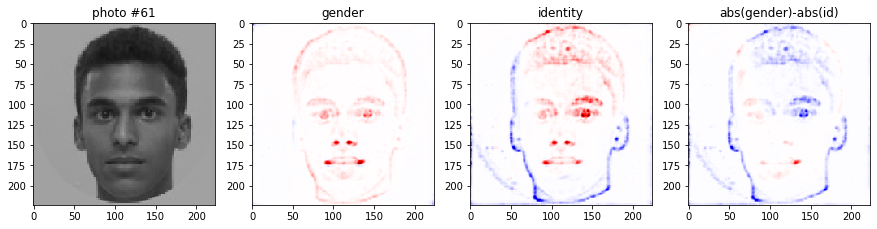

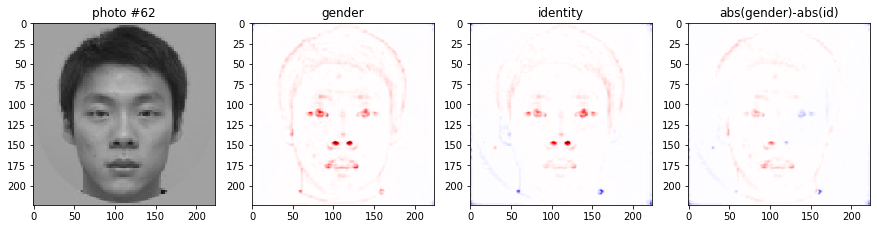

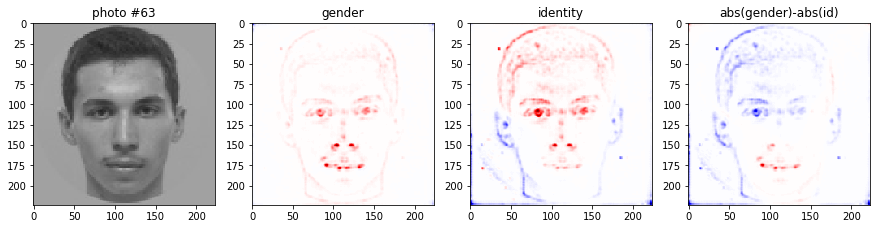

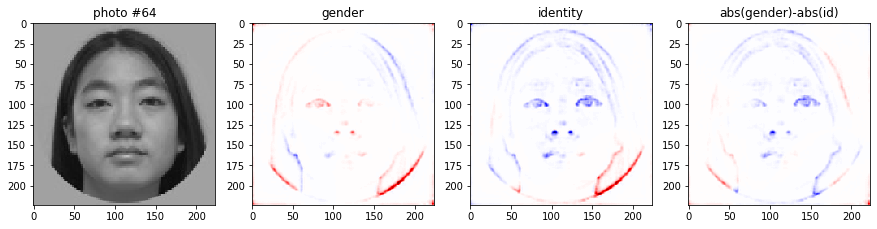

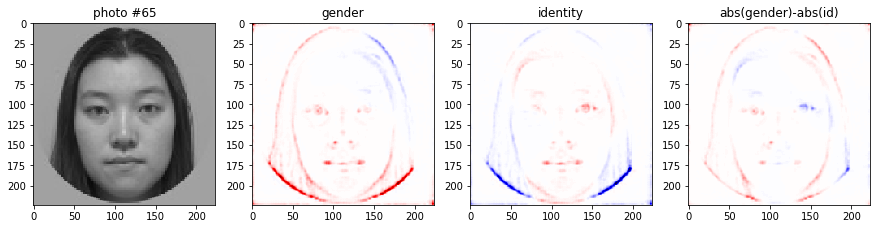

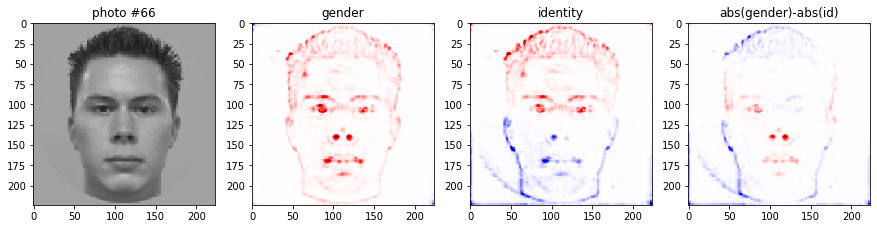

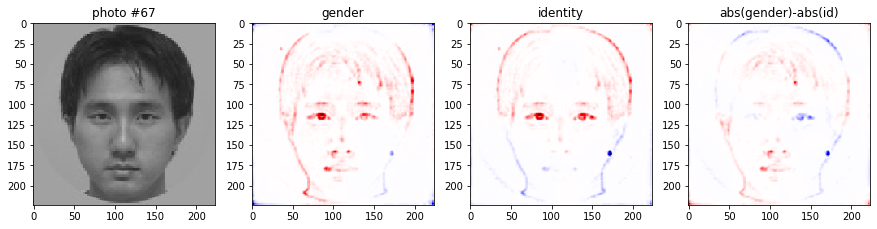

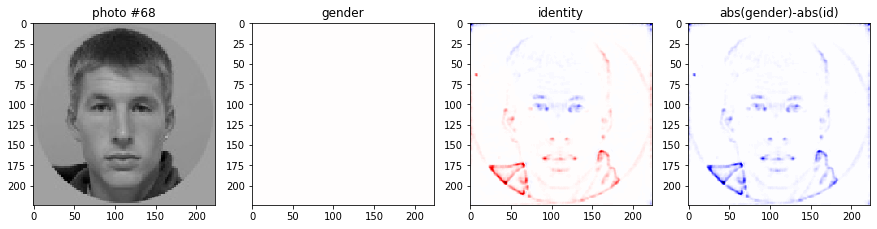

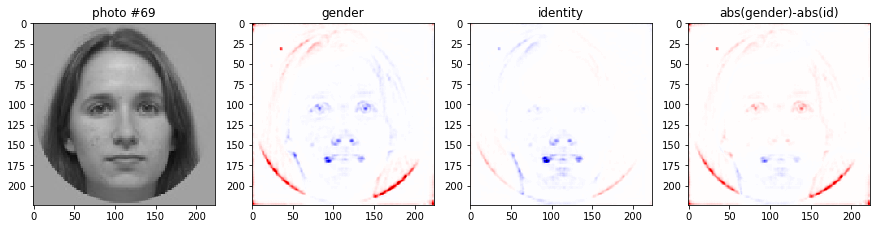

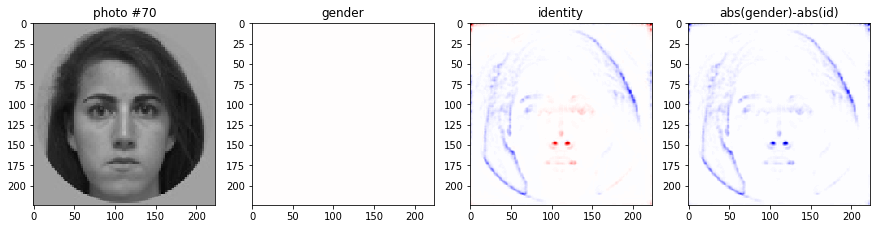

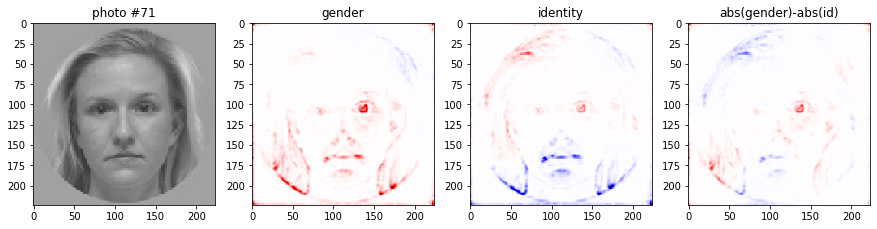

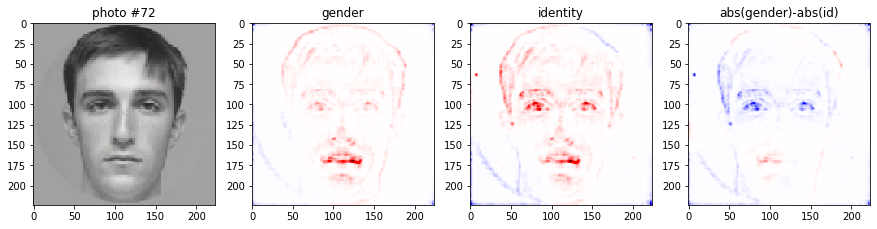

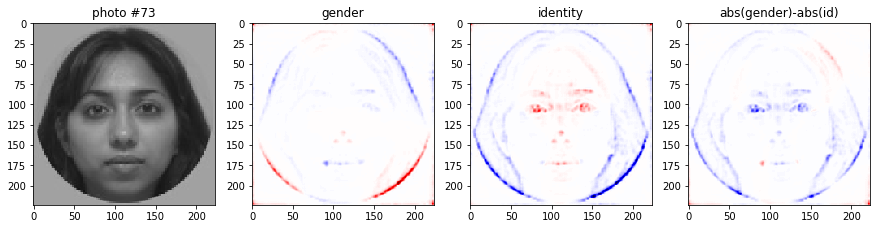

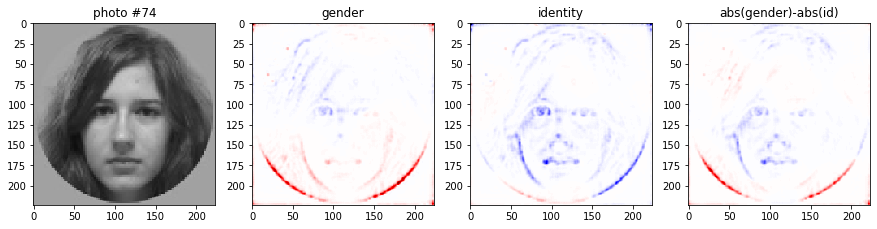

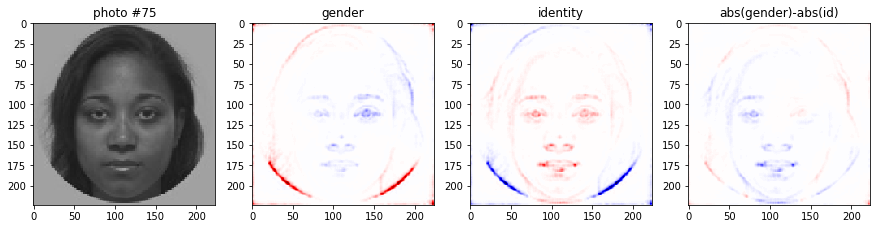

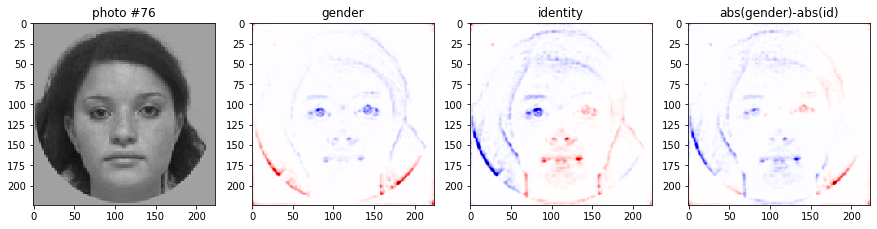

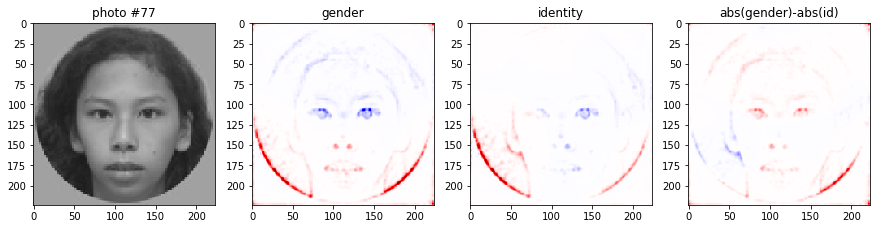

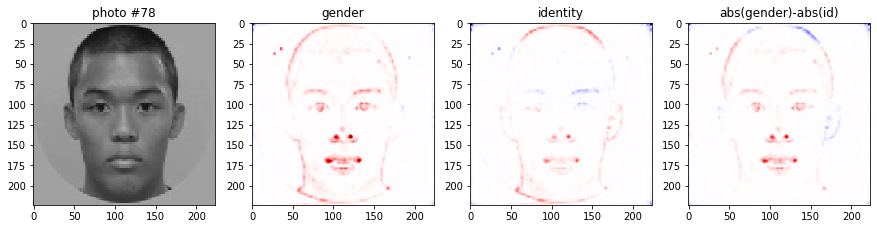

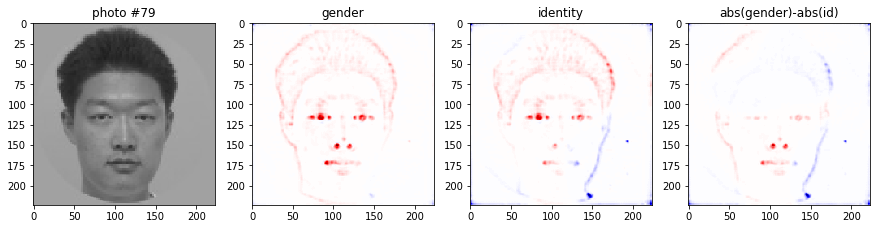

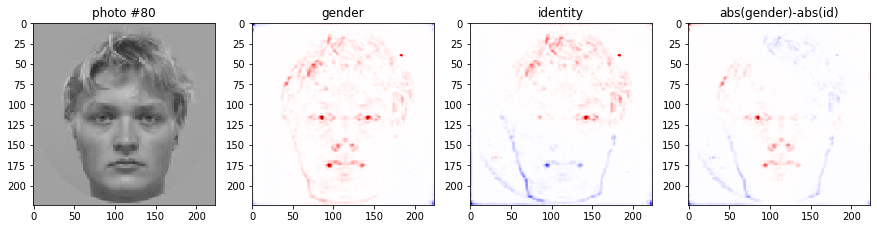

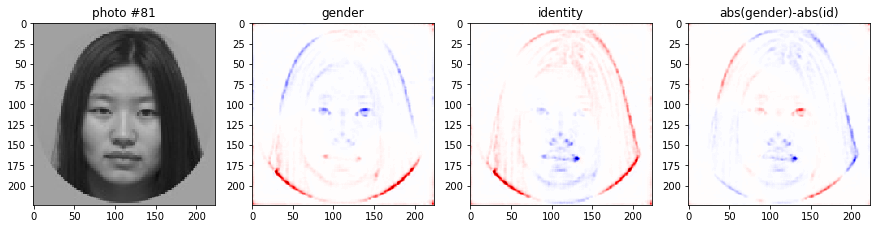

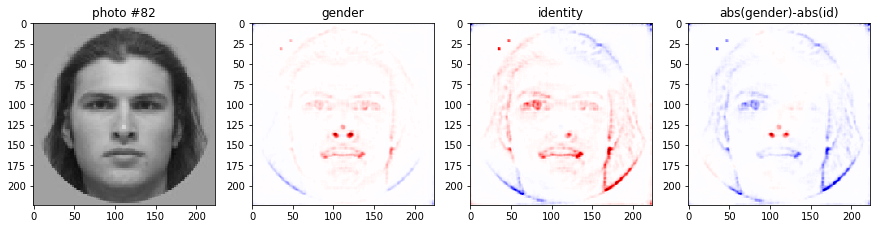

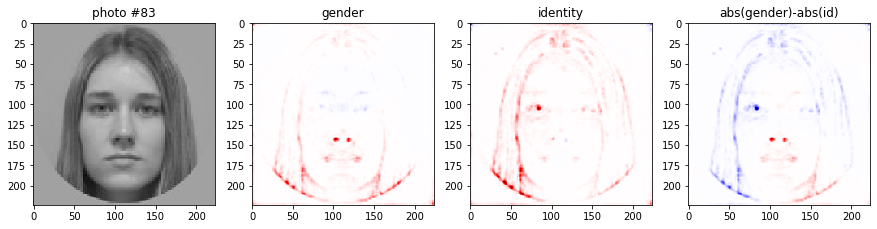

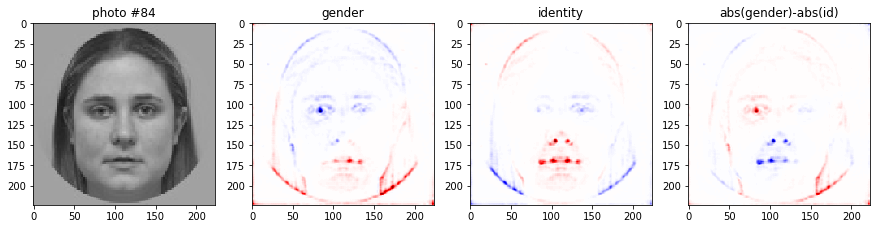

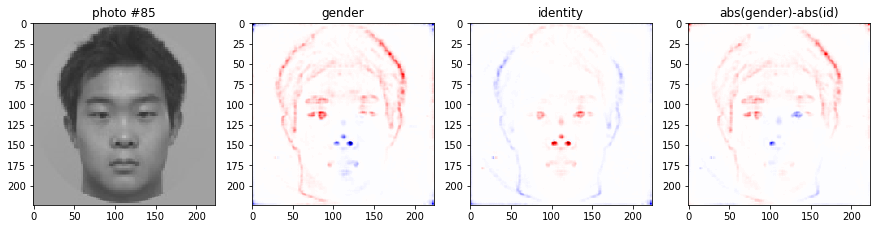

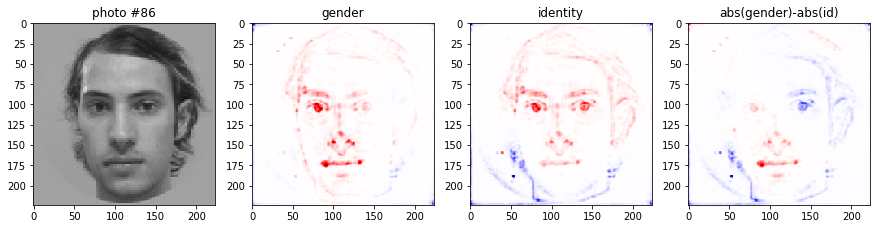

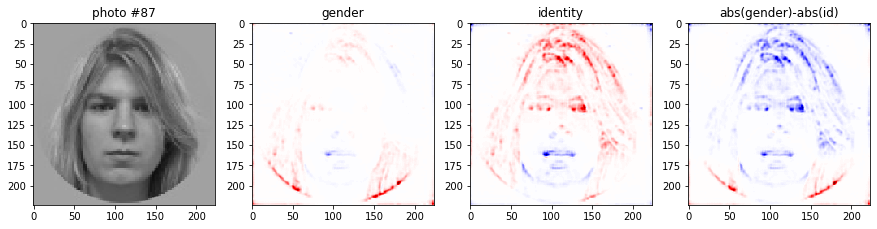

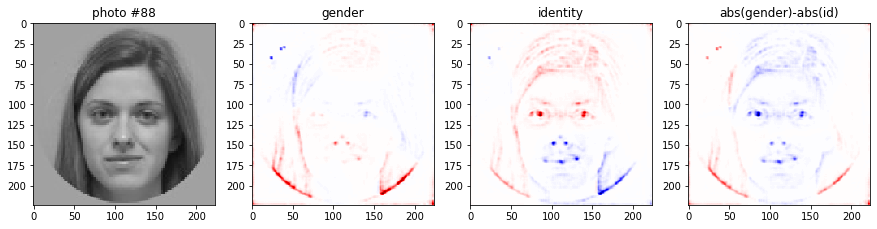

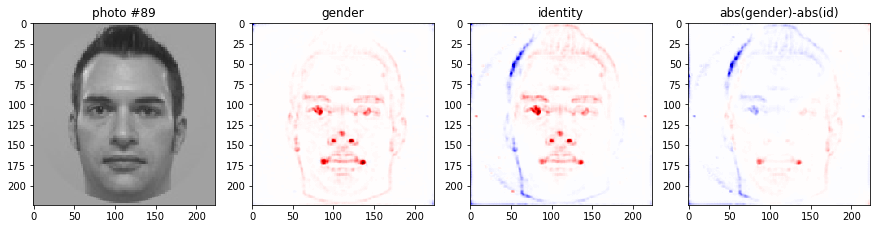

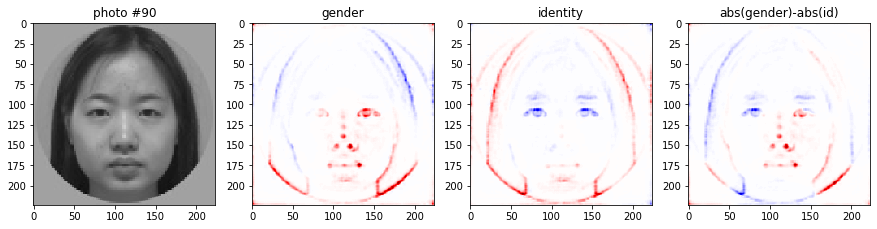

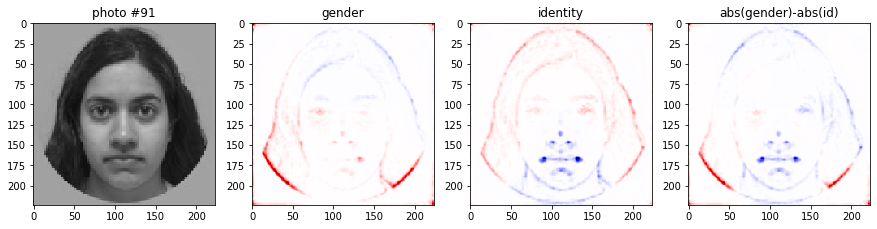

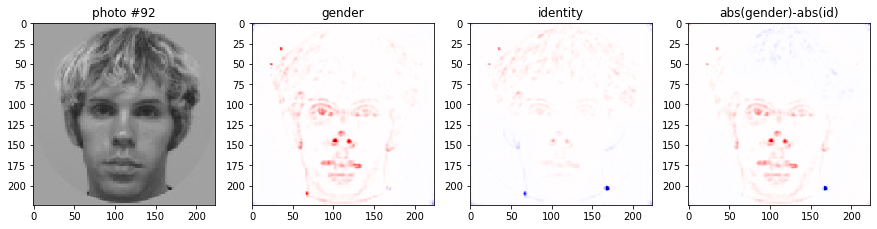

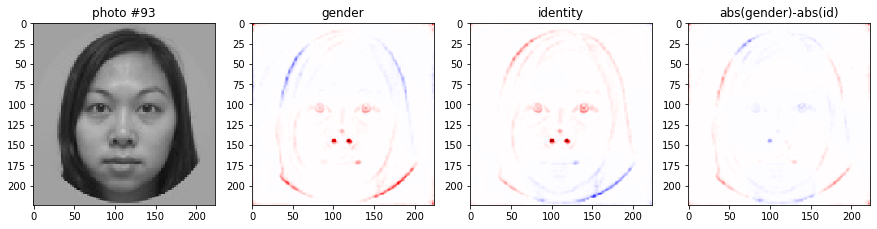

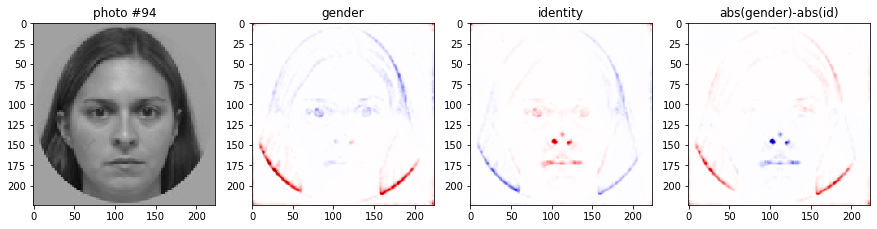

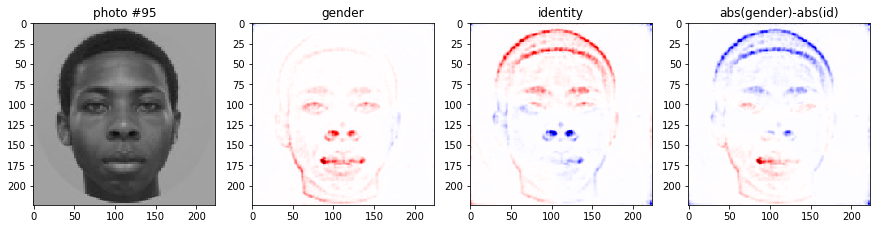

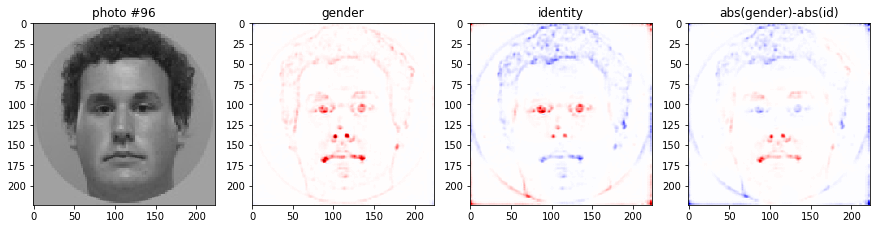

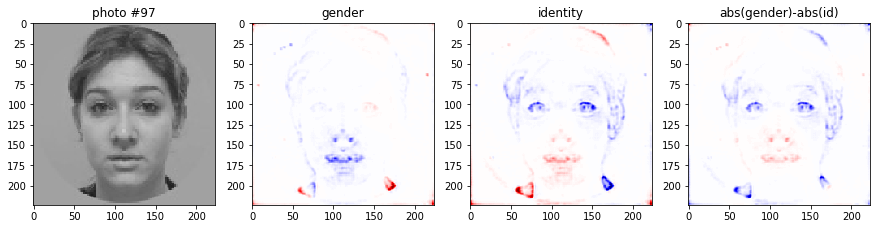

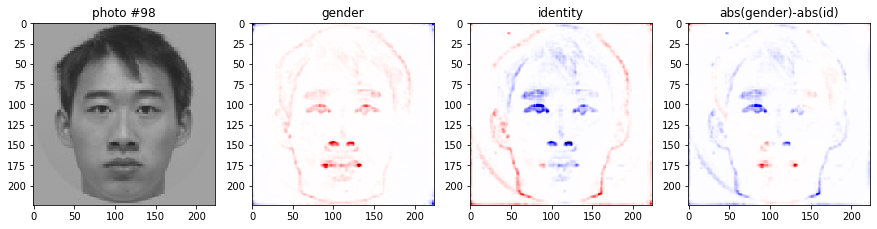

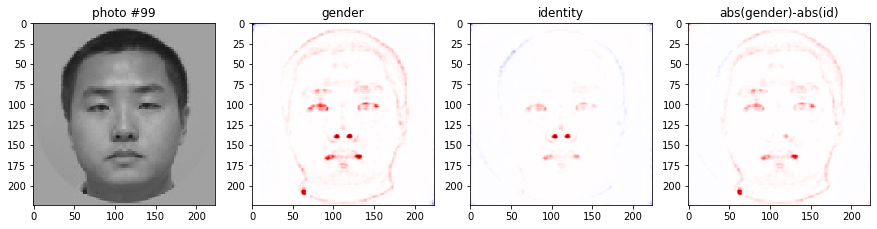

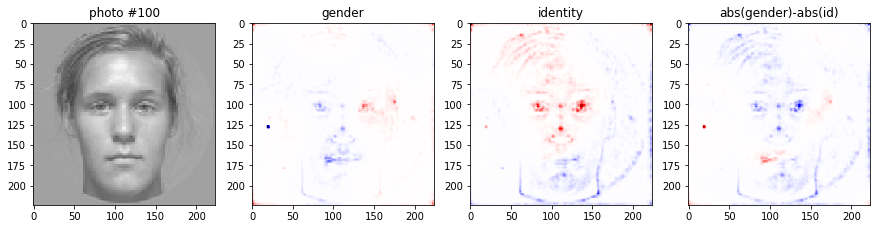

In [14]:
for i in range(len(rs_kgs_g)):
    plt.figure(figsize=(15,7))
    #plt.colorbar()
    plt.subplot(1,4,1)
    plt.imshow(ps_kgs_g[i])
    plt.title("photo #"+str(i))
    
    plt.subplot(1,4,2)
    plt.imshow(rs_kgs_g[i], cmap="seismic", clim=[-1,1])
    plt.title("gender")
    
    plt.subplot(1,4,3)
    plt.imshow(rs_kgs[i], cmap="seismic", clim=[-1,1])
    plt.title("identity")
    
    plt.subplot(1,4,4)
    plt.imshow(np.abs(rs_kgs_g[i]) - np.abs(rs_kgs[i]), cmap="seismic", clim=[-1,1])
    plt.title("abs(gender)-abs(id)")
    

## Diffs

In [ ]:
#split by gender
m_rs = []
f_rs = []
m_ps = []
f_ps = []
for i in range(len(front_view_filenames[:101])): #test on small piece first
    #print(front_view_filenames[i])
    if (( front_view_filenames[i].split('/')[7].split('_')[1]) == 'f') :
        f_rs.append(rs_kgs_g[i])
        f_ps.append(ps_kgs_g[i])
    else:
        m_rs.append(rs_kgs_g[i])
        m_ps.append(ps_kgs_g[i])
    

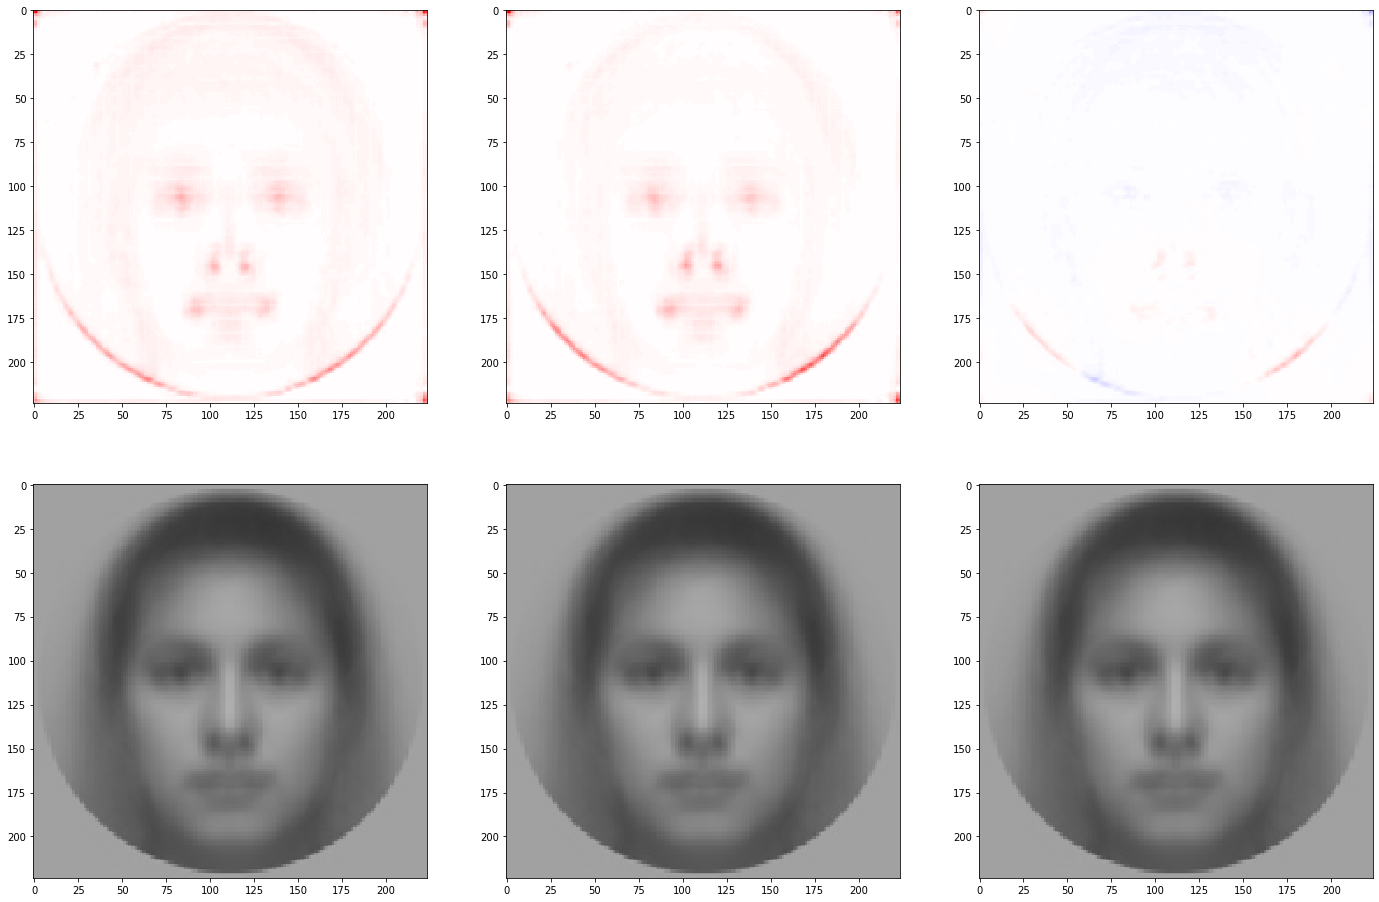

In [15]:
#task specific relevance difference
fig, axes = plt.subplots(figsize=(24, 16), nrows=2, ncols=3)
# average gender
axes[0, 0].imshow(np.mean(np.array(list(map(np.abs,rs_kgs))),axis=0), cmap="seismic", clim=[-1,1])
axes[1, 0].imshow(np.mean(np.array(list(map(image_utils.img_to_array,ps_kgs_g)))/255, axis=0))

# average id
axes[0, 1].imshow(np.mean(np.array(list(map(np.abs,rs_kgs_g))),axis=0), cmap="seismic", clim=[-1,1])
axes[1, 1].imshow(np.mean(np.array(list(map(image_utils.img_to_array,ps_kgs)))/255, axis=0))

# difference (gender - id)
axes[0, 2].imshow(np.mean(np.array(list(map(np.abs,rs_kgs_g))),axis=0)-np.mean(np.array(list(map(np.abs,rs_kgs))),axis=0), cmap="seismic", clim=[-1,1])
axes[1, 2].imshow(np.mean(np.array(list(map(image_utils.img_to_array,ps_kgs)))/255, axis=0));

## Iterative Analysis

Calculating frame 1 of 1 ...


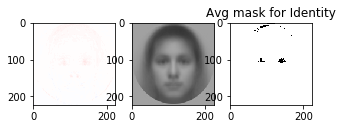

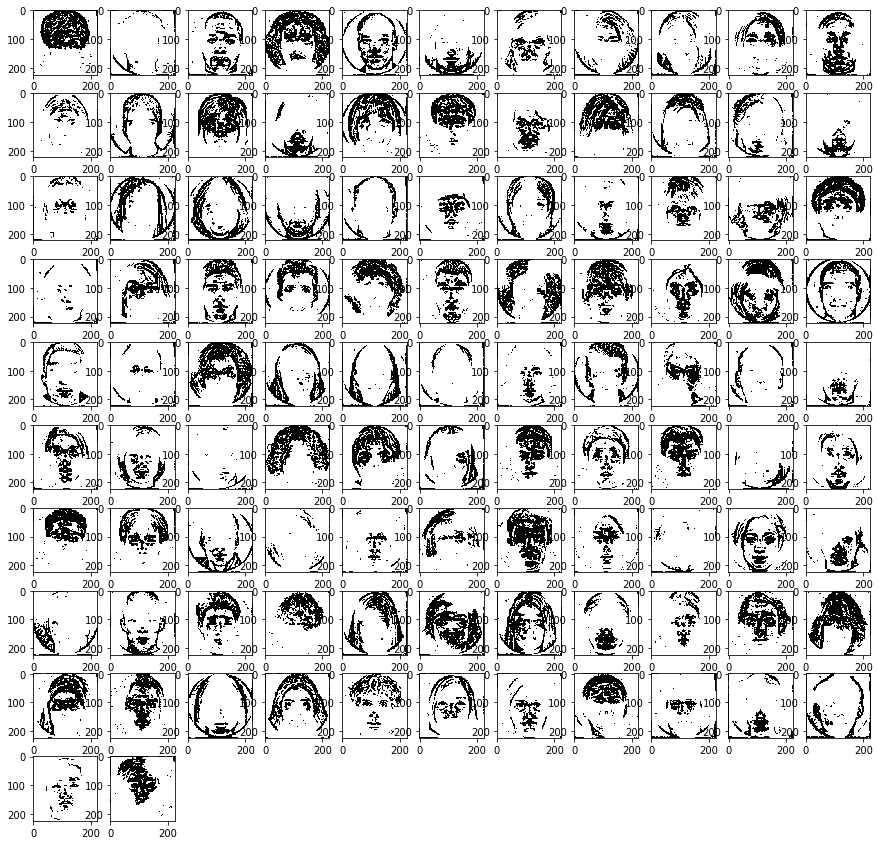

In [16]:
numframes = 1
numimages = 101
frames = []
individual_m_i = []
m = np.ones((224,224,3))

for i in range(numframes):
    print("Calculating frame",i+1,"of",numframes,"...")
    
    #calc relevance on images
    (rs_kgs,ps_kgs) = relevanceMap(front_view_filenames[:numimages], analyzers[0],hush=True, mask=m, BS=10)
    
    #plot this frame's relevance, and avg image used
    plt.figure(figsize=(5, 5))
    plt.subplot(1,3,1)
    plt.imshow(np.average(rs_kgs, axis=0), cmap="seismic", clim=[-1,1])
    plt.subplot(1,3,2)
    plt.imshow(np.average(np.array(list(map(image_utils.img_to_array,ps_kgs)))/255, axis=0))
    
    ###################
    #doing 101 individual masks instead of this!
    
    ##find top 25% of pixels
    #hinge = np.sort(np.average(rs_kgs, axis=0).ravel())[-int(224*224*0.25)];

    
    ##update mask
    #m[np.average(rs_kgs, axis=0) >= hinge] = 0
    
    
    ##plot mask
    #plt.subplot(1,3,3)
    #plt.imshow(m, cmap="seismic", clim=[0,1])
    ####################
    
    #make 101 individual masks
    for i in range(len(front_view_filenames[:numimages])):
        m = np.ones((224,224,3))
        #find top 25% of pixels
        hinge = np.sort(np.average(rs_kgs, axis=0).ravel())[-int(224*224*0.25)];
        
        #create this mask
        m[rs_kgs[i] >= hinge] = 0
        individual_m_i.append(np.copy(m))
    
    #plot avg mask
    plt.subplot(1,3,3)
    plt.imshow(np.round(np.mean(individual_m_i,axis=0)), cmap="seismic", clim=[0,1])
    plt.title("Avg mask for Identity")
    
    #plot masks
    plt.figure(figsize=(15,15))
    for i in range(len(individual_m_i)):
        plt.subplot(10,11,i+1)
        plt.imshow(individual_m_i[i], cmap="seismic", clim=[0,1])
    
    ##update frames
    #frames.append((rs_kgs,ps_kgs,np.copy(individual_m_i)))
    
    ##save to file so i dont have to run this over and over again
    #np.savez(file_locations.PATH_TO_CHECKPOINTS+"../relevances_id/frame"+str(i)+".npz", frames[i])
    scipy.io.savemat(file_locations.PATH_TO_CHECKPOINTS+'../relevances_id/mask.mat', {'masks': individual_m_i})
    


Calculating frame 1 of 1 ...


/share/kalanit/users/jnani/strelka_tf1_venv/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


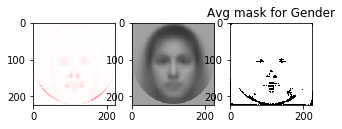

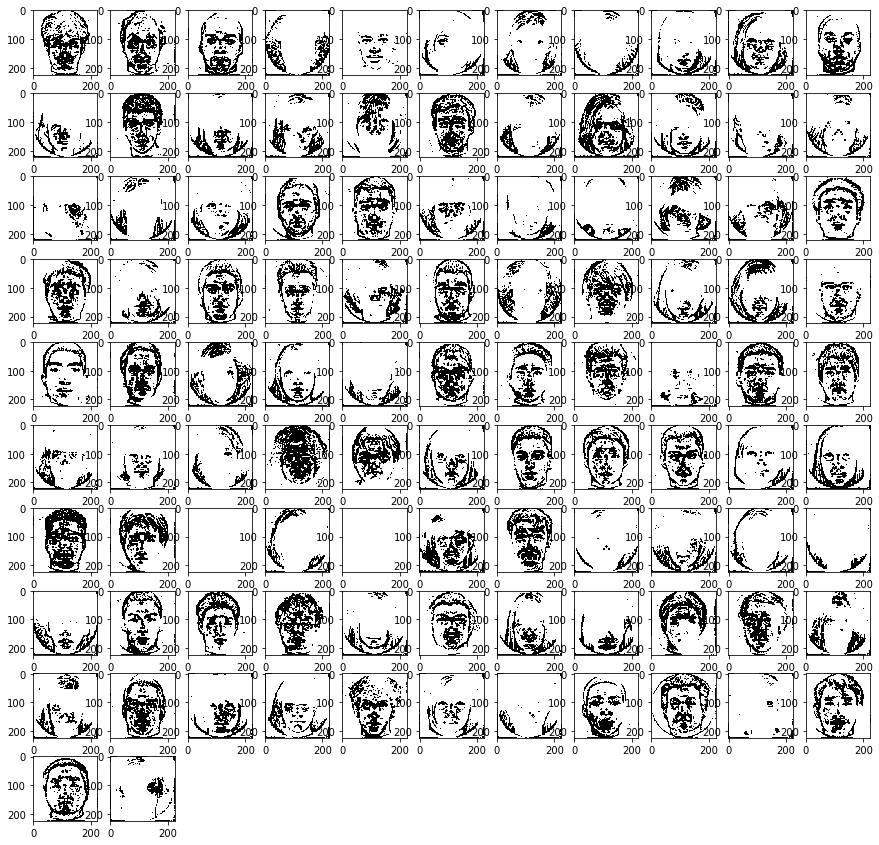

In [17]:
numframes = 1
numimages = 101
frames = []
m = np.ones((224,224,3))
individual_m_g = []

for i in range(numframes):
    print("Calculating frame",i+1,"of",numframes,"...")
    
    #calc relevance on images
    (rs_kgs_g,ps_kgs_g) = relevanceMap(front_view_filenames[:numimages], analyzers[1],hush=True, mask=m, BS=10)
    
    #plot this frame's relevance, and avg image used
    plt.figure(figsize=(5, 5))
    plt.subplot(1,3,1)
    plt.imshow(np.average(rs_kgs_g, axis=0), cmap="seismic", clim=[-1,1])
    plt.subplot(1,3,2)
    plt.imshow(np.average(np.array(list(map(image_utils.img_to_array,ps_kgs_g)))/255, axis=0))
    
    ###################
    #doing 101 individual masks instead of this!
    
    ##find top 25% of pixels
    #hinge = np.sort(np.average(rs_kgs_g, axis=0).ravel())[-int(224*224*0.25)];

    
    ##update mask
    #m[np.average(rs_kgs_g, axis=0) >= hinge] = 0
    
    
    ##plot mask
    #plt.subplot(1,3,3)
    #plt.imshow(m, cmap="seismic", clim=[0,1])
    ####################
    
    #make 101 individual masks
    for i in range(len(front_view_filenames[:numimages])):
        m = np.ones((224,224,3))
        #find top 25% of pixels
        hinge = np.sort(np.average(rs_kgs_g, axis=0).ravel())[-int(224*224*0.25)];
        
        #create this mask
        m[rs_kgs_g[i] >= hinge] = 0
        individual_m_g.append(np.copy(m))
    
    #plot avg mask
    plt.subplot(1,3,3)
    plt.imshow(np.round(np.mean(individual_m_g,axis=0)), cmap="seismic", clim=[0,1])
    plt.title("Avg mask for Gender")
    
    #plot masks
    plt.figure(figsize=(15,15))
    for i in range(len(individual_m_g)):
        plt.subplot(10,11,i+1)
        plt.imshow(individual_m_g[i], cmap="seismic", clim=[0,1])
    
    ##update frames
    #frames.append((rs_kgs,ps_kgs,np.copy(individual_m_i)))
    
    #save to file so i dont have to run this over and over again
    #np.savez(file_locations.PATH_TO_CHECKPOINTS+"../relevances_gender/frame"+str(i)+".npz", frames[i])
    scipy.io.savemat(file_locations.PATH_TO_CHECKPOINTS+'../relevances_gender/mask.mat', {'masks': individual_m_g})

In [23]:
#plot masks
    plt.figure(figsize=(15,15))
    for i in range(10):#len(individual_m_g)):
        plt.subplot(10,11,(i+1)*2)
        plt.imshow(individual_m_g[i], cmap="seismic", clim=[0,1])
    
        plt.subplot(10,11,((i+1)*2)+1)
        plt.imshow(individual_m_g[i], cmap="seismic", clim=[0,1])

## How do masks affect accuracy?

In [158]:
#create gender labels for frontview face evaluation
labels_id = []
labels_gender = []
for i in range(len(front_view_filenames)):
    n = 0 if (front_view_filenames[i].split('/')[7].split('_')[1] == 'f') else 1
    labels_gender.append([])
    labels_gender[i].extend(np.array([int(i == n) for i in range(2)]))
    
    n = int(front_view_filenames[i].split('/')[6])
    labels_id.append([])
    labels_id[i].extend(np.array([int(i == n) for i in range(len(front_view_filenames))]))

labels_id = np.array(labels_id)
labels_gender = np.array(labels_gender)
    
#apply identity masks to kgs frontview faces
frontview_masked_i = []
for i in range(len(front_view_filenames)):
    frontview_masked_i.append(ps_kgs[i] * individual_m_i[i])
frontview_masked_i = np.array(frontview_masked_i)

#apply gender masks to kgs frontview faces
frontview_masked_g = []
for i in range(len(front_view_filenames)):
    frontview_masked_g.append(image_utils.img_to_array(ps_kgs[i]) * individual_m_g[i])
frontview_masked_g = np.array(frontview_masked_g)

In [159]:
#run an evaluation for each model-masking combo
scores_id_nomask = id_model.evaluate(np.array(list(map(image_utils.img_to_array,ps_kgs))), labels_id)
scores_id_gmask = id_model.evaluate(frontview_masked_g, labels_id)
scores_id_idmask = id_model.evaluate(frontview_masked_i, labels_id)

scores_g_nomask = gender_model.evaluate(np.array(list(map(image_utils.img_to_array,ps_kgs_g))), labels_gender)
scores_g_gmask = gender_model.evaluate(frontview_masked_g, labels_gender)
scores_g_idmask = gender_model.evaluate(frontview_masked_i, labels_gender)

101/101 [==============================] - 0s 2ms/step


<Figure size 432x288 with 0 Axes>

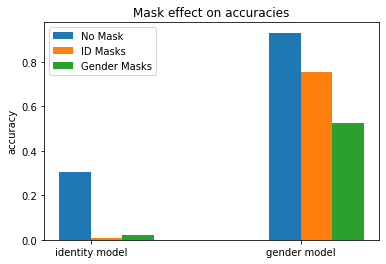

<Figure size 432x288 with 0 Axes>

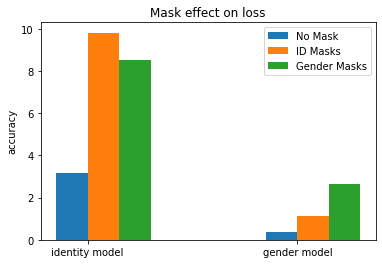

In [160]:
#plot on bar graph
plt.figure()
labels = ['identity model', 'gender model']
nomask_scores = [scores_id_nomask[1], scores_g_nomask[1]]
idmask_scores = [scores_id_idmask[1], scores_g_idmask[1]]
gmask_scores = [scores_id_gmask[1], scores_g_gmask[1]]

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, nomask_scores, width, label='No Mask')
rects2 = ax.bar(x + width/2, idmask_scores, width, label='ID Masks')
rects2 = ax.bar(x + 1.5*width, gmask_scores, width, label='Gender Masks')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('accuracy')
ax.set_title('Mask effect on accuracies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#plot on bar graph
plt.figure()
labels = ['identity model', 'gender model']
nomask_scores = [scores_id_nomask[0], scores_g_nomask[0]]
idmask_scores = [scores_id_idmask[0], scores_g_idmask[0]]
gmask_scores = [scores_id_gmask[0], scores_g_gmask[0]]

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, nomask_scores, width, label='No Mask')
rects2 = ax.bar(x + width/2, idmask_scores, width, label='ID Masks')
rects2 = ax.bar(x + 1.5*width, gmask_scores, width, label='Gender Masks')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('accuracy')
ax.set_title('Mask effect on loss')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend();

## Iterative-Gif Creation

In [ ]:
#load frames from file
lframes = []
for i in range(20):
    lframes.append(list(np.load("./iterative_relevances_lrp/frame"+str(i)+".npz", allow_pickle=True).values())[0])

In [ ]:
#thanks to Eli @ https://eli.thegreenplace.net/2016/drawing-animated-gifs-with-matplotlib/
import imageio
    
f = []
for i in range(20):
    #plot this frame's relevance, avg image used, and the mask
    fig, ax = plt.subplots(figsize=(30,20), nrows=2, ncols=3)
    
    #separate genders
    m_rs = []
    f_rs = []
    m_ps = []
    f_ps = []
    for k in range(len(front_view_filenames[:numimages])): #test on small piece first
        if (( front_view_filenames[k].split('/')[6].split('_')[1]) == 'f') :
            f_rs.append(lframes[i][0][k])
            f_ps.append(lframes[i][1][k])
        else:
            m_rs.append(lframes[i][0][k])
            m_ps.append(lframes[i][1][k])

    
    ax[0,0].imshow(np.average(lframes[i][0], axis=0), cmap="seismic", clim=[-1,1])
    ax[0,0].set_title('Average Relevance')
    
    ax[0,1].imshow(np.average(f_rs, axis=0)-np.average(m_rs, axis=0), cmap="seismic", clim=[-1,1])
    ax[0,1].set_title('Average Relevance (F(red)-M(blue))')
    
    if (i>0):
        lframes[i][2] += lframes[i-1][2]
    ax[0,2].imshow(lframes[i][2][:,:,0], cmap="gist_rainbow")
    ax[0,2].set_title('Mask used on input')
    
    ax[1,0].imshow(np.average(np.array(list(map(image_utils.img_to_array,f_ps)))/255, axis=0))
    ax[1,0].set_title('Average F face')
    
    ax[1,1].imshow(np.average(np.array(list(map(image_utils.img_to_array,m_ps)))/255, axis=0))
    ax[1,1].set_title('Average M face')

    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant
    #ax.set_ylim(0, y_max)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    f.append(image)

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./iterative_relevances_lrp.gif', f, fps=1)

## Gif
![SegmentLocal](iterative_relevances.gif "segment")